<img src="https://www.iscte-iul.pt/assets/images/logo_iscte_detailed.svg" style="width: 450px;margin-top:30px;" align ="center">

<div style= "font-size: 40px;  margin-top:40px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Part 2: <strong>Neural Network Modeling</strong></center></div>
<div style= "font-size: 40px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>of time series</center></div>

<div style= "font-size: 27px;font-weight:bold;line-height: 1.1; margin-top:40px; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Análise de Séries Temporais e Previsão 2024/2025</center></div> <br>

   <div style= "font-size: 20px;font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center> Grupo 7:</center></div>
   <div><center> Diogo Freitas | 104841 </center></div>
   <div><center> João Francisco Botas | 104782 </center></div>
   <div><center> Miguel Gonçalves | 105944 </center></div>
   <div><center> Ricardo Galvão | 105285 </center></div>

In [1]:
import logging

In [2]:
# Desativa mensagem constante dos dispositivos disponíveis para treino de modelos
class IgnorePLFilter(logging.Filter):
    def filter(self, record):
        keywords = ['available:', 'CUDA', 'LOCAL_RANK:']
        return not any(keyword in record.getMessage() for keyword in keywords)
    
logging.getLogger('pytorch_lightning.utilities.rank_zero').addFilter(IgnorePLFilter())
logging.getLogger('pytorch_lightning.accelerators.cuda').addFilter(IgnorePLFilter())

In [3]:
from fredapi import Fred
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [4]:
from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
from pathlib import Path
import os

In [5]:
os.environ['OMP_NUM_THREADS'] = '1'

In [6]:
from darts import TimeSeries
from darts.utils import statistics
from darts.metrics import mape, smape, rmse, r2_score
from sklearn.preprocessing import MaxAbsScaler
from darts.dataprocessing.transformers import Scaler

In [7]:
import seaborn as sns

In [8]:
import optuna

In [9]:
# Inicializa ficheiro de armazenamento de trials do Optuna
optuna_storage_path = "optuna_journal_storage.log"
lock_obj = optuna.storages.journal.JournalFileOpenLock(optuna_storage_path)
storage = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend(optuna_storage_path, lock_obj=lock_obj)
)

# Inicialização das Séries

In [10]:
fred = Fred(api_key="8ede227d95e33c5cdf2ea8a83577bc0a")

In [11]:
fred_series_ids = ["IHLIDXNSAGB", "IRLTLT01GBM156N", "QGBN628BIS", "UKNGDP", "GBRCPIALLMINMEI"]

In [12]:
fred_series_metadata = []
fred_series_list = []
for series in fred_series_ids:
    metadata = fred.get_series_info(series)
    series = fred.get_series(series, observation_end='2025-04-30').rename(metadata["title"])
    fred_series_metadata.append(metadata)
    fred_series_list.append(series)

In [13]:
economic_uncertainty = pd.read_csv("../data/UK_Daily_Policy_Data.csv")

In [14]:
economic_uncertainty["date"] = pd.to_datetime(economic_uncertainty.drop("daily_policy_index", axis=1))
economic_uncertainty = economic_uncertainty.drop(["day", "month", "year"], axis=1).set_index("date").squeeze()

In [15]:
data = fred_series_list.copy()
data.append(economic_uncertainty)

In [16]:
data_ts = [TimeSeries.from_series(series) for series in data]

In [17]:
[print(f"{idx} {series.title} {len(data_ts[idx])}") for idx, series in enumerate(fred_series_metadata)]
print(f"{len(data_ts) - 1} UK_Daily_Policy_Data {len(data_ts[5])}")

0 Job Postings on Indeed in the United Kingdom 1916
1 Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United Kingdom 783
2 Residential Property Prices for United Kingdom 227
3 Gross Domestic Product for United Kingdom 280
4 Consumer Price Indices (CPIs, HICPs), COICOP 1999: Consumer Price Index: Total for United Kingdom 842
5 UK_Daily_Policy_Data 8886


In [18]:
series_names = ["Job_Postings", "Interest_Rates", "Residential_Property_Prices", "GDP", "CPI", "Economic_Uncertainty"]

Escolha da série temporal a modelar:

In [19]:
series_chosen = 0
series = data_ts[series_chosen]
series_name = series_names[series_chosen]

Escolha das métricas a avaliar, incluindo seleção de uma principal para otimização de hiperparâmetros.

In [20]:
metrics = [smape, r2_score]
main_metric = metrics[0]
assert main_metric in metrics

In [21]:
splitting = 0.9
visualizing = 0.7

In [22]:
train, test = series.split_before(splitting)
train, val = train.split_before(splitting)

Scaling das séries temporais para treino das redes neuronais.

In [23]:
scaler = MaxAbsScaler()
transformer = Scaler(scaler)

In [24]:
train = transformer.fit_transform(train)
val = transformer.transform(val)
test = transformer.transform(test)

# Modelação de Time Series com Redes Neuronais

O pacote *darts* possibilita o uso de várias arquiteturas de redes neuronais para modelação de séries temporais. Para a construção e treino das redes, utiliza como backend o pacote pytorch-lightning, um framework para pytorch.

Utilizamos uma GPU para treinar os nossos modelos localmente. 

In [25]:
import torch
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)
torch.set_float32_matmul_precision('high')

NVIDIA GeForce RTX 5070 Ti


In [26]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import Callback

In [27]:
# Criacao de um callback de logging dos losses de treino e validacao
class LossRecorder(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []

    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss_history.append(trainer.callback_metrics["train_loss"].item())
        self.val_loss_history.append(trainer.callback_metrics["val_loss"].item())


In [28]:
loss_recorder = LossRecorder()
# stop training when validation loss does not decrease more than 0.00001 (`min_delta`) 
# over a period of 5 epochs (`patience`)
early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.00001,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [early_stopper, loss_recorder]}

In [29]:
from darts.models import RNNModel, BlockRNNModel

### Treino de LSTM

Construção da primeira rede neuronal com hiperparâmetros default.

In [30]:
lstm_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    n_rnn_layers=3,
    dropout=0,
    batch_size=64,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM",
    log_tensorboard=True,
    random_state=7,
    training_length=int(len(val)/2),     # Estes hiperparametros sao um fator da dimensao da serie a ser modelada
    input_chunk_length=int(len(val)/4),  # para garantir inputs de dimensao adequada
    # output_chunk_length=12,
    force_reset=True,
    save_checkpoints=True,
    pl_trainer_kwargs=pl_trainer_kwargs,
)


In [31]:
# Treino do modelo com validacao
lstm_model.fit(train, val_series=val, verbose=True)


  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.6 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=3, dropout=0, training_length=87, batch_size=64, n_epochs=100, optimizer_kwargs={'lr': 0.001}, model_name=LSTM, log_tensorboard=True, random_state=7, input_chunk_length=43, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000020794612710>, <__main__.LossRecorder object at 0x0000020794612830>]})

O modelo apresenta uma aprendizagem adequada ao longo das épocas de treino.

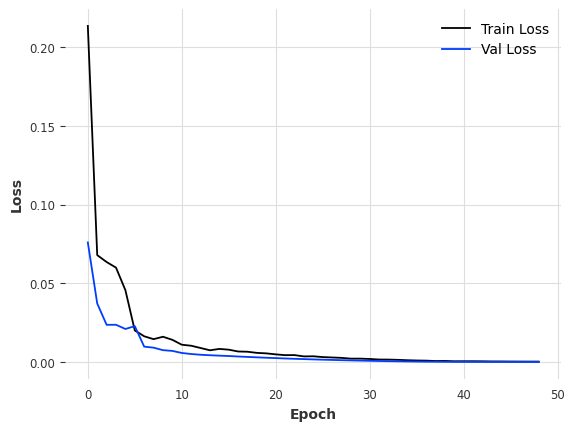

In [32]:
plt.plot(loss_recorder.train_loss_history, label='Train Loss')
plt.plot(loss_recorder.val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
lstm_model.load_from_checkpoint("LSTM", best=True)

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=3, dropout=0, training_length=87, batch_size=64, n_epochs=100, optimizer_kwargs={'lr': 0.001}, model_name=LSTM, log_tensorboard=True, random_state=7, input_chunk_length=43, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x00000209FA081480>, <__main__.LossRecorder object at 0x00000209FA0817E0>]})

In [34]:
val_preds = transformer.inverse_transform(lstm_model.predict(len(val)))

Predicting: |                                                                                    | 0/? [00:00<…

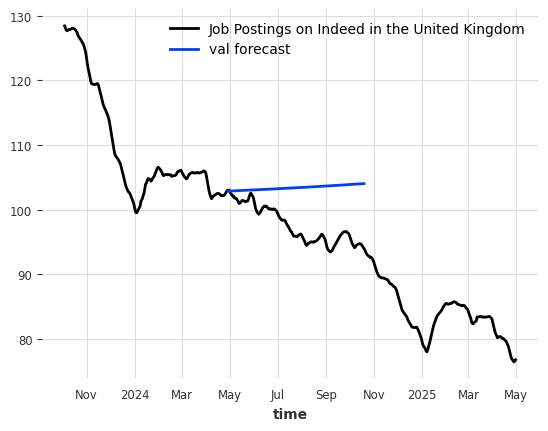

In [35]:
series.drop_before(visualizing).plot()
val_preds.plot(label="val forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

O modelo 

### Treino de NBEATS

Como experiência, treinamos também uma arquitetura de redes neuronais mais

In [36]:
loss_recorder = LossRecorder()

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.00001,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [early_stopper, loss_recorder]}

In [37]:
# https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html
from darts.models import NBEATSModel
nbeats_model = NBEATSModel(
    input_chunk_length=24, 
    output_chunk_length=12, 
    batch_size=64,
    n_epochs=100, 
    random_state=7, 
    optimizer_kwargs={"lr": 1e-4},
    model_name="NBEATS",
    log_tensorboard=True,
    pl_trainer_kwargs=pl_trainer_kwargs
)
nbeats_model.fit(train, val_series=val, verbose=True)


  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, batch_size=64, n_epochs=100, random_state=7, optimizer_kwargs={'lr': 0.0001}, model_name=NBEATS, log_tensorboard=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x00000209FA202AD0>, <__main__.LossRecorder object at 0x00000209FA0825F0>]})

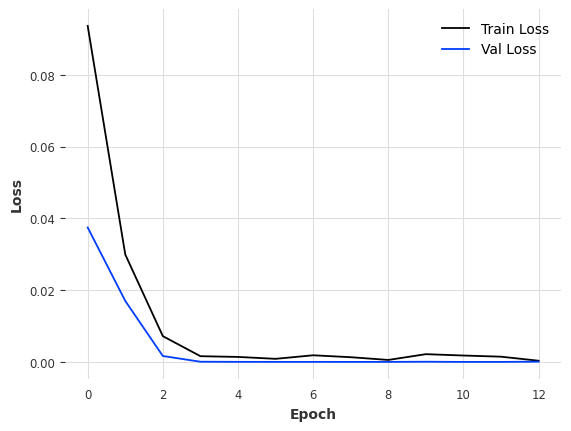

In [38]:
plt.plot(loss_recorder.train_loss_history, label='Train Loss')
plt.plot(loss_recorder.val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
len(val)

174

In [40]:
val_preds = transformer.inverse_transform(nbeats_model.predict(len(val)))

Predicting: |                                                                                    | 0/? [00:00<…

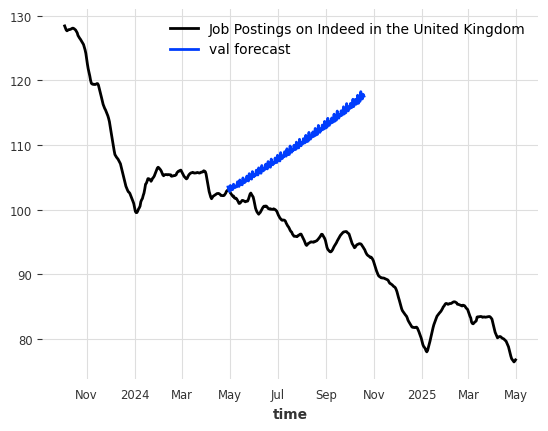

In [41]:
series.drop_before(visualizing).plot()
val_preds.plot(label="val forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

# Backtesting NNs

In [42]:
from darts.models import NaiveSeasonal

In [43]:
base_model = NaiveSeasonal(K=1)

In [44]:
base_model.model_name = "Baseline"

In [45]:
def backtest_models(
    series: TimeSeries, 
    models: list, 
    horizons: list=[1, 3, 7], 
    points_to_test: int=len(test), 
    verbose=True, retrain=False, baseline=base_model, metrics=metrics
):
    backtest_results = dict()
    if baseline:
        models = [baseline, *models]
    for horizon in sorted(horizons):
        print(f"Backtesting {horizon} {series.freq} horizon")
        backtests = []
        for model in models:
            if model.model_name == "Baseline":
                backtest = model.historical_forecasts(
                    transformer.transform(series),
                    start=len(series) - points_to_test,
                    forecast_horizon=horizon,
                    retrain=True,
                    verbose=False,
                )
            else:
                print(f"Backtesting {model.model_name}")
                backtest = model.historical_forecasts(
                    transformer.transform(series),
                    start=len(series) - points_to_test,
                    forecast_horizon=horizon,
                    retrain=retrain,
                    verbose=verbose,
                )
            backtest = transformer.inverse_transform(backtest)
            backtests.append(backtest)
        backtest_results[horizon] = {
            str(model.model_name): (backtests[i], {metric.__name__: round(metric(series, backtests[i]), 3) for metric in metrics}) 
            for i, model in enumerate(models)
        }
    return backtest_results

In [46]:
def plot_backtest_results(
    series: TimeSeries, 
    backtest_results: dict, 
    points_to_test: int=len(test),
):
    for horizon, model in backtest_results.items():
        plt.figure(figsize=(12, 6))
        series.drop_before(int(len(series) - 1.5*points_to_test)).plot(label='data')
        for model_name, (backtest, metrics) in model.items():
            backtest.plot(lw=3, label=f'{model_name}, {metrics}')
        plt.title(f'Backtests with {horizon} {series.freq} forecast horizon')
        plt.legend()
        plt.show()

In [47]:
models = [nbeats_model, lstm_model]

In [48]:
results = backtest_models(
    series, 
    models=models, 
    metrics=metrics,
    points_to_test=len(test)
)

Backtesting 1 <Day> horizon
Backtesting NBEATS


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting NBEATS


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting NBEATS


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

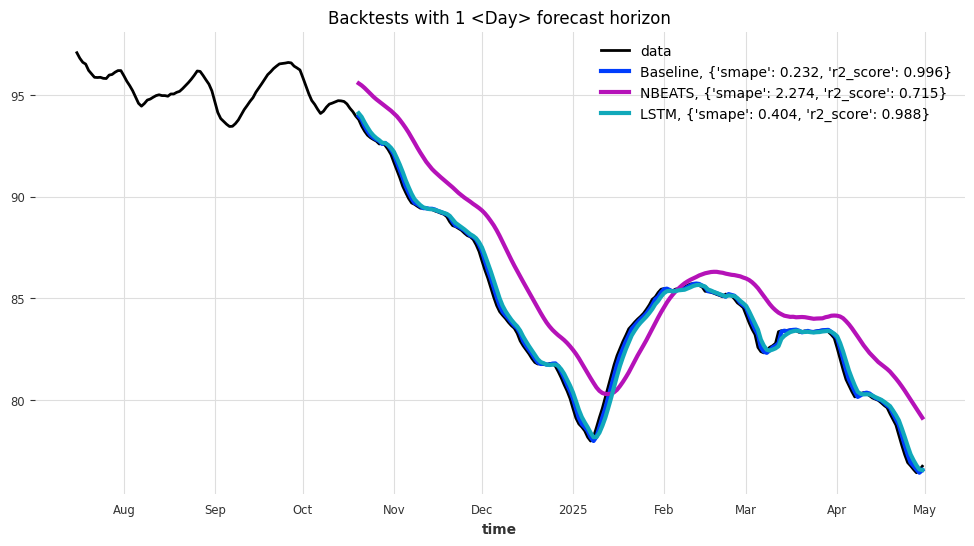

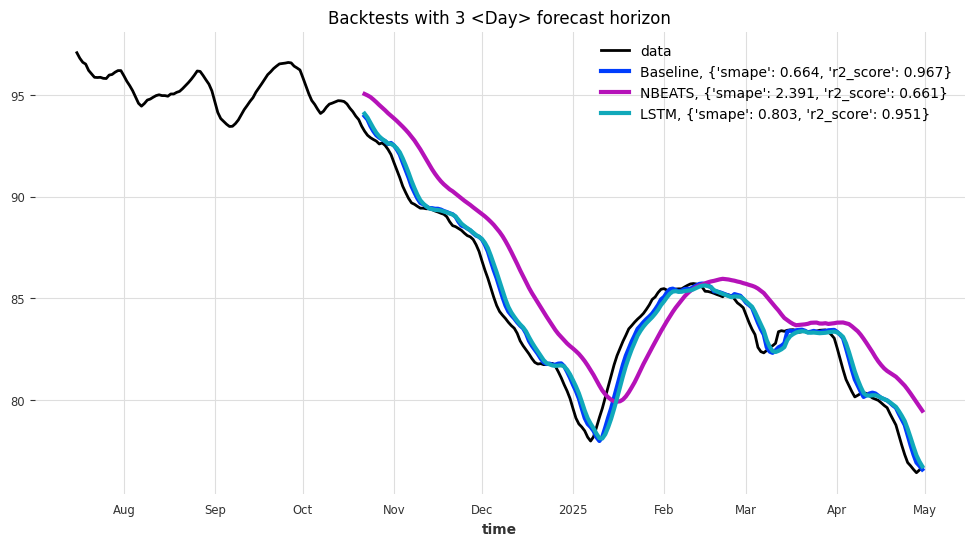

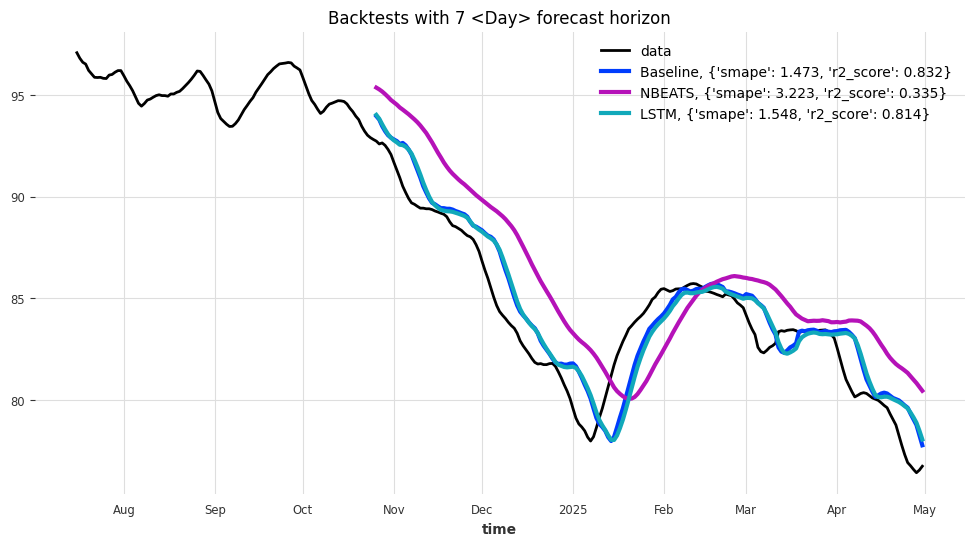

In [49]:
plot_backtest_results(series, results, points_to_test=len(test))

In [50]:
import optuna

In [51]:
def train_RNN(params):
    early_stopper = EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=0.05,
        mode='min',
    )
    pl_trainer_kwargs={"callbacks": [early_stopper]}
    
    model = RNNModel(
        **params,
        n_epochs=100,
        model_name=params["model"],
        log_tensorboard=True,
        random_state=7,
        training_length=int(len(val)/2),
        force_reset=True,
        save_checkpoints=True,
        pl_trainer_kwargs=pl_trainer_kwargs,
    )
    model.fit(train, val_series=val, verbose=False)
    model.load_from_checkpoint(params["model"], best=True)
    return model

In [52]:
def optimize_RNN(trial: optuna.Trial):
    params = {
        "model": trial.suggest_categorical("model", ["RNN", "GRU", "LSTM"]),
        "hidden_dim": trial.suggest_int("hidden_dim", 2, 50),
        "n_rnn_layers": trial.suggest_int("n_rnn_layers", 1, 5),
        "dropout": trial.suggest_float("dropout", 0, 0.3),
        "batch_size": 2 ** trial.suggest_int("log2(batch_size)", 4, 8),  # will be a power of two
        "input_chunk_length": trial.suggest_int("input_chunk_length", 1, int(len(val)/4)),
        "optimizer_kwargs": {
            "lr": trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
        }
    }
    if params["n_rnn_layers"] == 1:
        params["dropout"] = 0
        
    trial.set_user_attr("model_params", params)
    
    model = train_RNN(params)
    backtests = backtest_models(
        series[train.time_index.union(val.time_index)], 
        models=[model], 
        horizons=[1, 2, 3, 5, 7],
        metrics=metrics,
        points_to_test=len(val),
    )
    results = [model_dict[params["model"]][1][main_metric.__name__]/(horizon**0.5) 
               for horizon, model_dict in backtests.items()]
    
    return sum(results) / len(results)

In [53]:
# Create optuna study with defined function and storage
study = optuna.create_study(
    direction="minimize",
    storage=storage,
    study_name=f"{series_name}_{main_metric.__name__}_avghorizons_RNNfamily_study",
    load_if_exists=True
)

[I 2025-05-15 10:25:43,136] Using an existing study with name 'Job_Postings_smape_avghorizons_RNNfamily_study' instead of creating a new one.


In [54]:
# Optimize for n_trials, using one thread, timeout of 5 min
study.optimize(optimize_RNN, n_trials=1, n_jobs=1)  # , timeout=30)

C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-15 10:25:49,048] Trial 400 finished with value: 0.5337555100173992 and parameters: {'model': 'LSTM', 'hidden_dim': 38, 'n_rnn_layers': 2, 'dropout': 0.04556389877027829, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.05312556130695124}. Best is trial 399 with value: 0.2648762954237142.


In [55]:
study_df = study.trials_dataframe()
study_df["duration"] = study_df["duration"].dt.total_seconds()

In [56]:
study_df.head(1)

,number,value,datetime_start,datetime_complete,duration,params_dropout,params_hidden_dim,params_input_chunk_length,params_learning_rate,params_log2(batch_size),params_model,params_n_rnn_layers,user_attrs_model_params,state
0,0,1.000061,2025-05-14 21:36:27.556996,2025-05-14 21:36:39.057026,11.50003,0.010205,15,31,0.084433,4,LSTM,3,"{'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_lay...",COMPLETE


In [57]:
study_grouped = study_df.groupby("params_model").agg({
    "value": ["count", "mean", "min", "max", "idxmin"],
    "duration": ["mean", "min", "max"],  
})
study_grouped

value                                          duration  \
             count       mean       min         max idxmin      mean   
params_model                                                           
GRU            355   1.591761  0.264876   87.862163    399  5.625804   
LSTM            24  11.078599  0.533756  123.480753    400  6.606235   
RNN             22   5.400624  0.598870   26.812111    261  6.078485   

                                   
                   min        max  
params_model                       
GRU           4.302156  13.650981  
LSTM          5.020001  11.997386  
RNN           4.497051  15.066079

In [58]:
best_models = [train_RNN(
    params
) for params in study_df.loc[study_grouped[("value", "idxmin")]]["user_attrs_model_params"]]


C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


In [59]:
results = backtest_models(
    series, 
    models=best_models, 
    horizons=[1, 2, 3, 5, 7, 15, 30], 
    metrics=metrics,
    points_to_test=len(test)
)


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

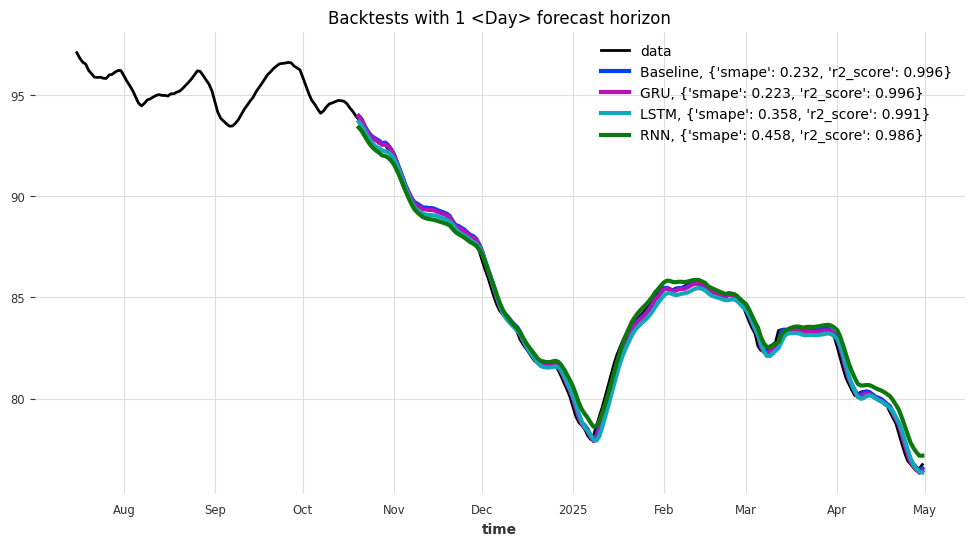

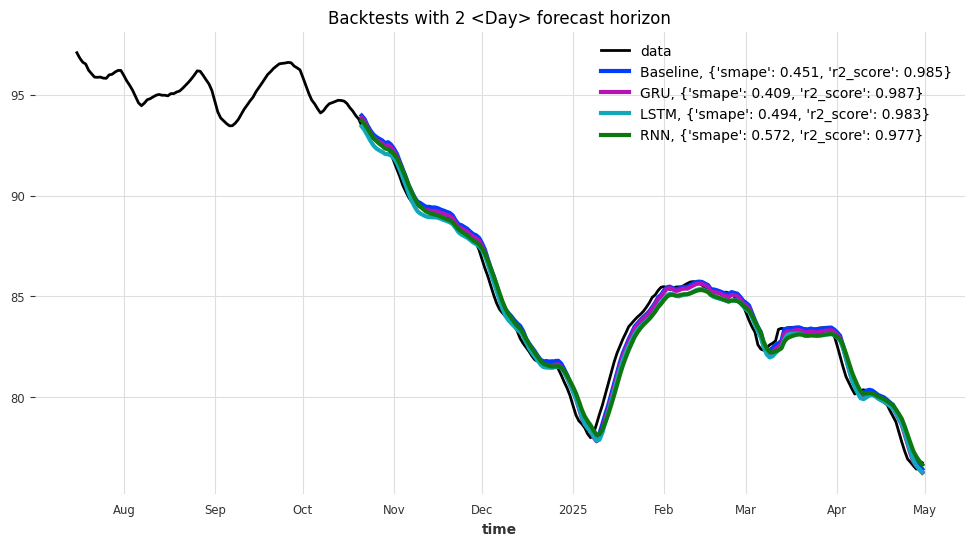

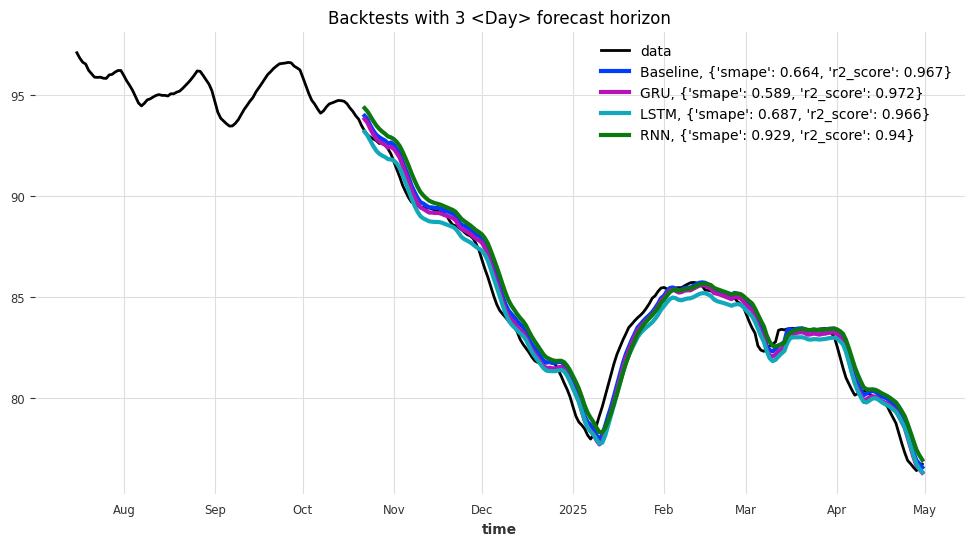

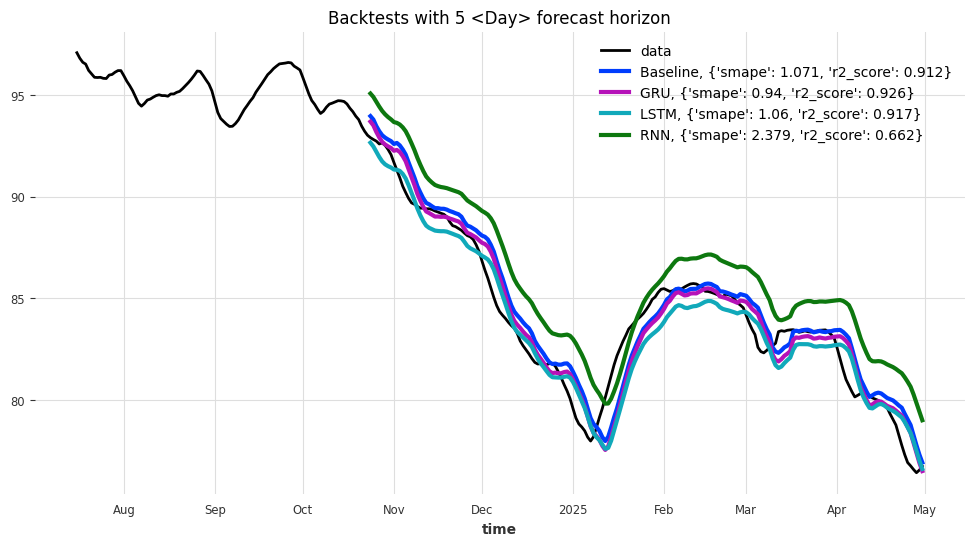

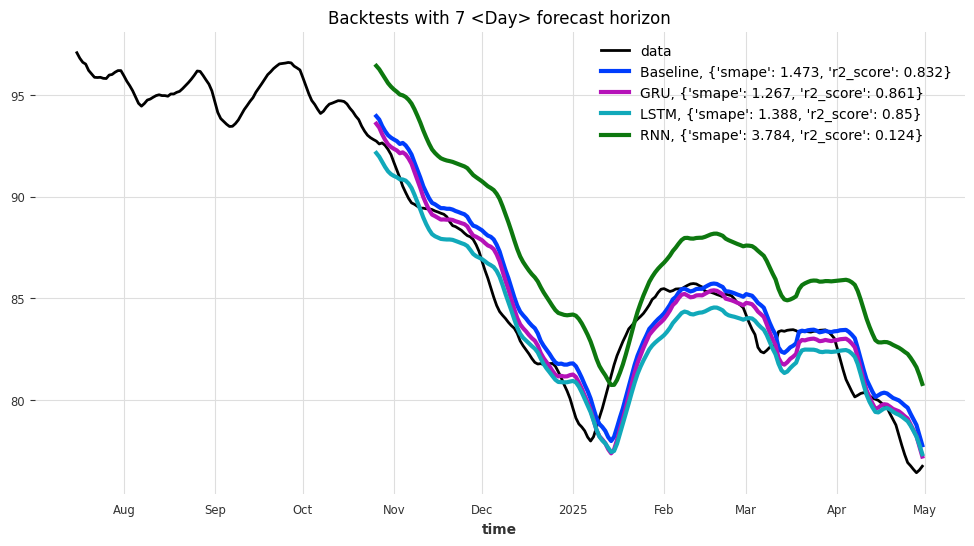

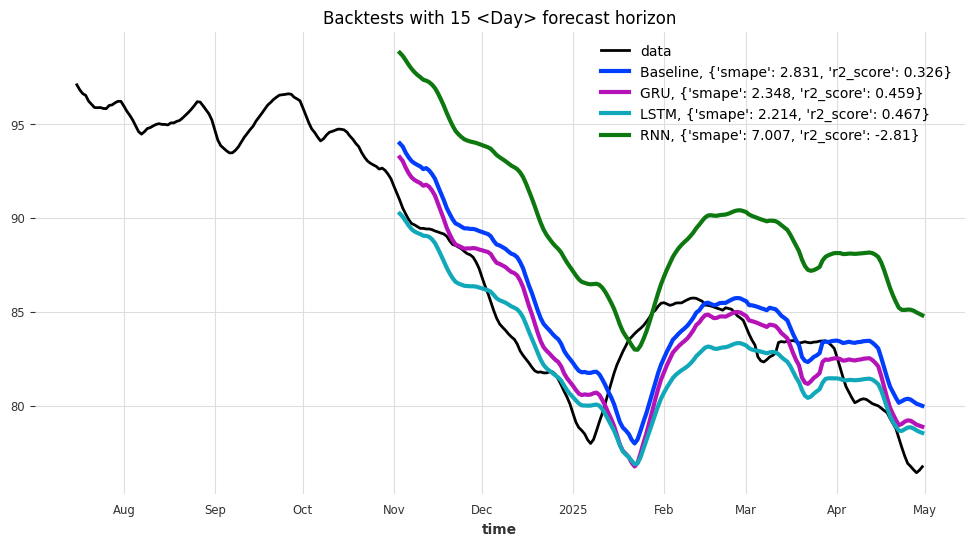

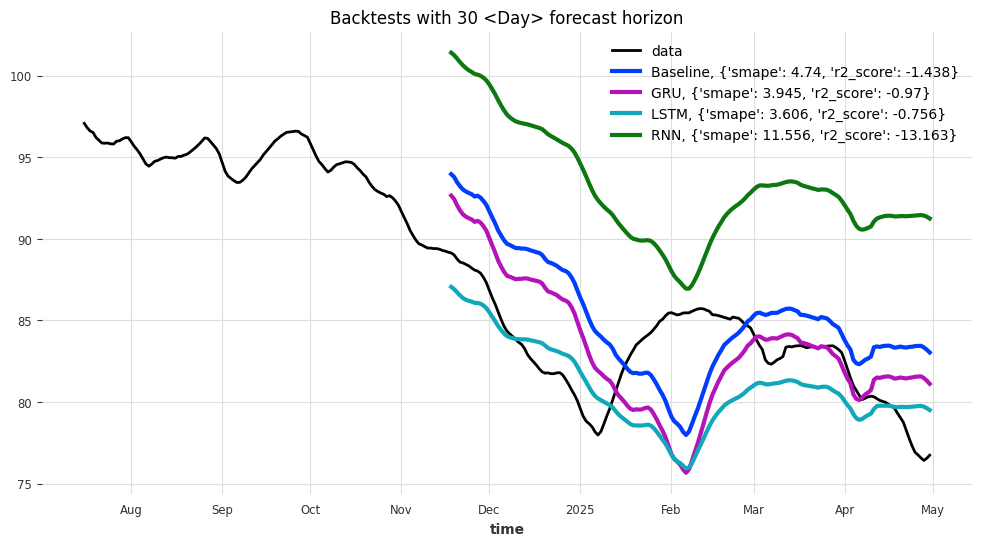

In [60]:
plot_backtest_results(
    series, 
    results, 
    points_to_test=len(test)
)


### Comparação da otimização dos modelos da família RNN

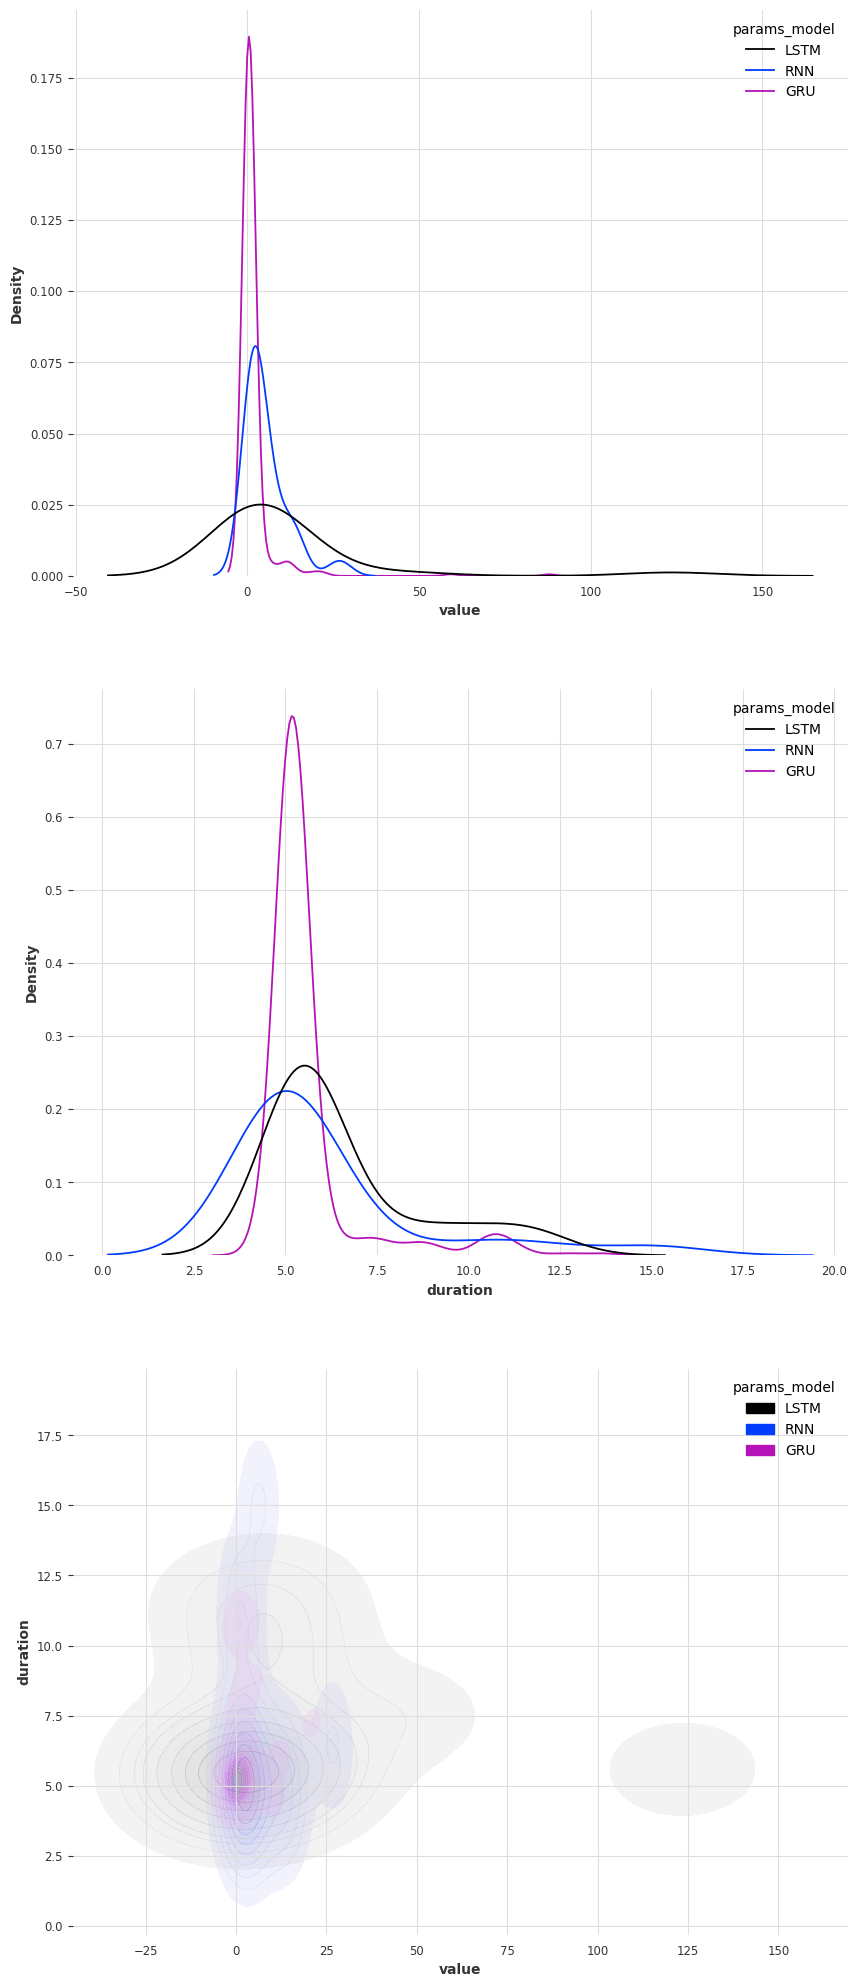

In [61]:
# sns.set(style='dark',)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 25))
sns.kdeplot(study_df, x="value", hue="params_model", ax=ax1, common_norm=False)
sns.kdeplot(study_df, x="duration", hue="params_model", ax=ax2, common_norm=False)
sns.kdeplot(study_df, x="value", y="duration", hue="params_model", ax=ax3, common_norm=False, fill=True, alpha=.2)

plt.show()